# Tutorial demonstrating verification of v1 1000hPa temp against jra55

#### Import pyLatte package

In [3]:
from pylatte import utils
from pylatte import verif

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
%matplotlib inline

#### The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

#### The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [5]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# zclient

# Construct xarray objects for forecasts and observations

#### (The CAFE cookbook will replace these code blocks)

In [28]:
# Resampling details -----
resample_freq = '1MS' # Must be '1MS' for monthly
resample_method = 'mean'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/011_tmp/cat/'
obsv_filename = 'jra.55.tmp.1000.1958010100_2016123118.nc'

In [29]:
# Initialization dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2/2002','3/2002' , freq='1MS')  # Must be '1MS' for monthly

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
no_leap = 2001
n_incr = len(pd.date_range('1/1/' + str(no_leap),
                           '12/1/' + str(no_leap+FCST_LENGTH-1),
                           freq=resample_freq)) # number of lead_time increments
lead_times = range(1,n_incr+1)

### Construct forecasts xarray object

In [30]:
# import pdb, traceback, sys

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with utils.timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + fcst_filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + fcst_filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst = ds_fcst.rename({'time' : 'lead_time'})
    ds_fcst['lead_time'] = lead_times

    # Initialize 'init_date' coordinate -----
    ds_fcst.coords['init_date'] = init_dates[0]
    ds_fcst = ds_fcst.expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with utils.timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + fcst_filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + fcst_filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk = ds_chunk.rename({'time' : 'lead_time'})
        ds_chunk['lead_time'] = lead_times

        # Concaneate along 'init_date' dimension/coordinate -----
        ds_chunk.coords['init_date'] = init_date
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

Gathering data for forecast started on 2-2002...
   Elapsed: 5.88490104675293 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.954745769500732 sec


#### Rechunk

In [31]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

    # Overwrite init_dates in case didn't fully load -----
    init_dates = ds_fcst.init_date.values

   Elapsed: 0.7967948913574219 sec


### Construct observations xarray object

In [32]:
# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with utils.timer():
    print(f'Gathering data for observations...')
    
    ds_temp1 = xr.open_mfdataset(obsv_folder + obsv_filename, autoclose=True)
    
    # Standardize naming -----
    ds_temp1 = ds_temp1.rename({'initial_time0_hours':'time',
                                      'g0_lon_3':'lon',
                                      'g0_lat_2':'lat',
                                      'TMP_GDS0_ISBL':'temp'})

    # Resample to desired frequency -----
    ds_temp1 = ds_temp1.resample(freq=resample_freq, dim='time', how=resample_method)
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    # Initialize xarray object for first lead_time -----
    start_index = np.where(ds_temp1.time == np.datetime64(init_dates[0]))[0].item()
    ds_obsv = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))
    ds_obsv.coords['init_date'] = init_dates[0]
    ds_obsv = ds_obsv.expand_dims('init_date')
    ds_obsv = ds_obsv.rename({'time' : 'lead_time'})
    ds_obsv['lead_time'] = lead_times
    
    # Loop over remaining lead_time -----
    for init_date in init_dates[1:]:
        start_index = np.where(ds_temp1.time == np.datetime64(init_date))[0].item()
        ds_temp3 = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))

        # Concatenate along 'lead_time' dimension/coordinate -----
        ds_temp3 = ds_temp3.rename({'time' : 'lead_time'})
        ds_temp3['lead_time'] = lead_times
        ds_temp3.coords['init_date'] = init_date
        ds_obsv = xr.concat([ds_obsv, ds_temp3],'init_date') 

Gathering data for observations...
   Elapsed: 4.60844349861145 sec


#### Rechunk

In [33]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

   Elapsed: 0.003927707672119141 sec


In [43]:
ds_fcst['temp'].sel(pfull=1000,method='nearest',drop=True)

<xarray.DataArray 'temp' (init_date: 2, lead_time: 24, ensemble: 11, lat: 90, lon: 144)>
dask.array<shape=(2, 24, 11, 90, 144), dtype=float64, chunksize=(1, 24, 11, 90, 144)>
Coordinates:
  * lead_time  (lead_time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * lon        (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 ...
  * lat        (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 ...
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
  * init_date  (init_date) datetime64[ns] 2002-02-01 2002-03-01

In [49]:
ds_obsv['temp'].squeeze().drop('lv_ISBL1')

<xarray.DataArray 'temp' (init_date: 2, lead_time: 24, lat: 145, lon: 288)>
dask.array<shape=(2, 24, 145, 288), dtype=float64, chunksize=(2, 1, 145, 288)>
Coordinates:
  * lead_time  (lead_time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lat        (lat) float32 90.0 88.75 87.5 86.25 85.0 83.75 82.5 81.25 ...
  * init_date  (init_date) datetime64[ns] 2002-02-01 2002-03-01

# Methods for probabilistic forecasts

## Rank histogram

#### E.g. for temperature at 1000hPa averaged over Australia

In [50]:
with utils.timer():
    # Region of interest -----
    region = (-38.0, -11.0, 113.0 , 153.0) # (lat_min,lat_max,lon_min,lon_max)

    da_fcst = utils.calc_boxavg_latlon(ds_fcst['temp'].sel(pfull=1000,method='nearest',drop=True), region).compute()
    da_obsv = utils.calc_boxavg_latlon(ds_obsv['temp'].squeeze().drop('lv_ISBL1'), region).compute()

   Elapsed: 189.47670698165894 sec


#### Rank the data and compute histograms as a function of lead time

In [51]:
with utils.timer():
    rank_histogram = verif.compute_rank_histogram(da_fcst, da_obsv, indep_dims='init_date')

   Elapsed: 0.05634307861328125 sec


   Elapsed: 1.0230159759521484 sec


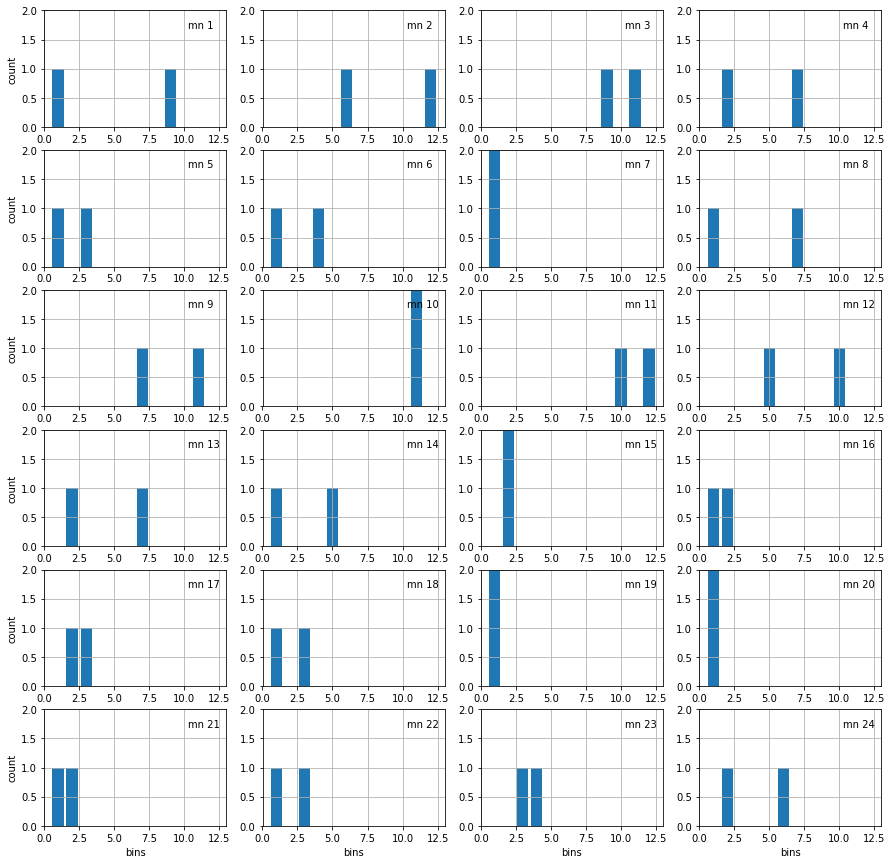

In [52]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.bar(rank_histogram.bins,rank_histogram.isel(lead_time=idx, drop=True))
        ax.set_ylim(0,rank_histogram.max())
        ax.text(10.3,0.85*rank_histogram.max(),'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('count')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('bins')

#### Rank the data and compute histograms for all lead times

In [54]:
with utils.timer():
    rank_histogram = verif.compute_rank_histogram(da_fcst, da_obsv, indep_dims=('init_date','lead_time'))

   Elapsed: 0.008453845977783203 sec


   Elapsed: 0.03739309310913086 sec


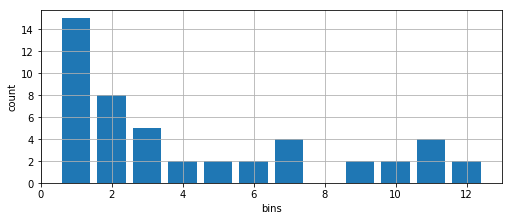

In [55]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,3))

    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.grid()
    ax1.bar(rank_histogram.bins,rank_histogram)
    ax1.set_xlabel('bins')
    ax1.set_ylabel('count');

## (Continuous) ranked probability score

In [ ]:
with utils.timer():
    # Specify bins for computation of cdf -----
    bins = np.linspace(0,200,20)

    # Compute ranked probability score -----
    rps = verif.compute_rps(da_fcst, da_obsv, bins=bins, indep_dims='init_date', ensemble_dim='ensemble')

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(rps['lead_time'],rps,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Ranked probability score');

# Methods for continuous variables

## Additive bias error

## Multiplicative bias error

## Mean absolute error

## Mean squared error

## Root mean squared error

#### Plot as a function of lead time

# Close dask client

In [ ]:
# with utils.timer():
#     client.close()